# Potresi

V projektni nalogi bom analizirala podatke o potresih od [tukaj](http://www.emsc-csem.org/) (European-Mediterranean Seismological Centre). Odločila sem se za potrese, ki so se zgodili v prvih dveh tednih oktobra (torej do 15. oktobra), ker da ta časovni okvir ravno pravšnje število podatkov - nekaj več kot 1300 potresov.

Na navedeni strani najdete podatke o zadnjih potresih po svetu (podatke sicer pridobivajo avtomatsko od približno 70 opazovalnic, ki so večinoma v Evropi, zaznajo pa seveda potrese z vsega sveta) - na primer čas potresa, lokacijo (v koordinatah in opisno), globino in magnitudo. Kdorkoli lahko prispeva komentar oziroma fotografijo, če je potres začutil ali opazil posledice (recimo razpoke na hiši). Za posamezen potres, ki je pritegnil vašo pozornost, lahko pridobite ogromno podatkov, ki pa jih na tem mestu ne bomo obravnavali, ker za analizo niso posebej zanimivi.

#### Opomba

Če vas potresi zelo zanimajo, si oglejte tudi [to projektno nalogo](https://github.com/TinaKrasovec/Potresi-po-Evropi-zadnjih-nekaj-let-z-magnitudo-4). Podobnost je naključna, poskusili pa sva delati tako, da se analiza ne prekriva preveč. Pri delu nisva sodelovali.

## Uvod
Naložimo csv datoteko in si oglejmo nekaj vrstic za občutek.

In [1]:
import pandas as pd
pd.options.display.max_rows = 15


%matplotlib inline

In [2]:
podatki = pd.read_csv('potresi_koncni.csv', index_col = 'id')
podatki[:7]

,leto,mesec,dan,ura,minuta,sekunda,DOL,dolzina,SIR,sirina,globina,magnituda,regija
id,,,,,,,,,,,,,
537411,2016,10,15,23,40,55.1,E,34.31,N,38.13,4,2.7,CENTRAL TURKEY
537458,2016,10,15,23,17,42.6,E,27.72,N,38.93,6,2.6,WESTERN TURKEY
537380,2016,10,15,23,6,59.1,E,20.69,N,39.76,15,4.3,GREECE
537552,2016,10,15,22,43,13.2,E,38.94,N,19.21,8,3.6,WESTERN TURKEY
537310,2016,10,15,22,30,26.1,E,71.70,N,41.26,15,3.7,EASTERN UZBEKISTAN
537551,2016,10,15,22,27,50.9,E,38.94,N,19.29,8,3.6,WESTERN TURKEY
537553,2016,10,15,22,19,42.0,E,39.75,N,59.75,12,2.6,GREECE


## Kje so se zgodili potresi?

Večkrat smo že slišali, da živimo na potresno zelo živahnem območju. Izkaže pa se, da se v smislu potresov v začetku oktobra v Sloveniji ni veliko zgodilo. Opazovalnice so zabeležile en sam potres na našem območju, zato se najbrž spodobi, da ga izpišemo.

In [3]:
podatki[podatki.regija == 'SLOVENIA']

,leto,mesec,dan,ura,minuta,sekunda,DOL,dolzina,SIR,sirina,globina,magnituda,regija
id,,,,,,,,,,,,,
536262,2016,10,10,11,43,41.6,E,14.59,N,45.94,2,2.0,SLOVENIA


In [4]:
podatki.loc[536262]

leto             2016
mesec              10
dan                10
ura                11
minuta             43
sekunda          41.6
DOL                 E
dolzina         14.59
SIR                 N
sirina          45.94
globina             2
magnituda           2
regija       SLOVENIA
Name: 536262, dtype: object

Kako zanimivo! Potres se je zgodil v ponedeljek, 10. oktobra ob 11:43, ko so potekale vaje za programiranje.

V katerih državah pa se je zgodilo največ potresov?

In [5]:
stevilo_regije = podatki['regija'].value_counts()
stevilo_regije

WESTERN TURKEY                      242
GREECE                               69
CENTRAL TURKEY                       65
OKLAHOMA                             58
EASTERN TURKEY                       57
VIRGIN ISLANDS REGION                56
CENTRAL ITALY                        54
                                   ... 
VERACRUZ, MEXICO                      1
MENDOZA, ARGENTINA                    1
DOMINICA REGION, LEEWARD ISLANDS      1
BONIN ISLANDS, JAPAN REGION           1
SOUTH OF ALEUTIAN ISLANDS             1
JUJUY, ARGENTINA                      1
OREGON                                1
Name: regija, dtype: int64

Turčija je očitno potresno zelo zanimiva država, saj med prvimi petimi regijami nastopi kar trikrat s skupno več kot 350 potresi. Presenetljivo torej že zelo površen pregled pokaže, da se je približno vsak četrti potres zgodil v Turčiji.

Opazimo pa tudi težavo. Sklepali bi, da so potresno aktivna območja deljena v manjše regije (kot zgoraj Turčija in recimo Čile) zato, da tisti, ki se s tem ukvarjajo, že na prvi pogled bolj natančno vedo, kje je bil potres. Recimo pa, da nas ne zanima, v katerem delu države se je potres zgodil, ampak samo država, ker bodo v tem primeru podatki preglednejši.

### Funkcija, ki regijo spremeni v državo

Spodnja funkcija iz regije približno naredi državo (tabeli dodamo stolpec "drzava"). Zakaj samo približno? Ime regije je zapisano v več oblikah in manjšinski del teh opisov funkcija ohrani, čeprav niso idealni. Spodaj je za vsako obliko napisano, kaj funkcija pretvori_v_drzavo z njo naredi:

- imenovanje regije s stranmi neba (zahodna, osrednja ...): V tem primeru ohranimo samo ime države
- zapis oblike 'mesto/pokrajina, država': V tem primeru zbrišemo vse pred vejico
- širše območje neke države (predpostavljam, da gre za otočja), npr 'FIJI REGION': ohranimo samo ime države
- zaradi neznanega razloga je Kalifornija včasih imenovana 'CALIF.' (pri drugih državah tega nisem opazila): Spremenimo v 'CALIFORNIA'
- območje na morju ('OFFSHORE ...' ali 'NEAR THE COAST OF ...'): Izbrišemo opis območja

En opis, ki ga nisem popravljala, je recimo mejno območje med dvema državama (kot recimo 'CHINA-LAOS BORDER REG'). Dobiti stoplec, ki bi vseboval izključno samo države, pa je iz teh podatkov skoraj nemogoče. Ena izmed regij, kot vidimo zgoraj, so npr. Pireneji, gorovje med Španijo in Francijo. Tega ne moremo popraviti z nobeno funkcijo.

In [18]:
def pretvori_v_drzavo2(reg):
    odvec = {'WESTERN': 8, 'EASTERN': 8, 'CENTRAL': 8, 'SOUTHER': 9, 'NORTHER': 9, 'OFFSHOR' : 9, 'NEAR TH' : 18}
    zacetek = reg[:7]
    
    if ', ' in reg:
        vejica = reg.index(',')
        nova_regija = reg[vejica + 2:]
        return pretvori_v_drzavo(nova_regija)
    elif reg[-7:] == ' REGION':
        nova_regija = reg[:-7]
        return pretvori_v_drzavo(nova_regija)
    elif zacetek in odvec:
        nova_regija = reg[odvec[zacetek]:]
        return pretvori_v_drzavo(nova_regija)
    elif reg[-7:] == 'CALIF.':
        return 'CALIFORNIA'
    else:
        return reg

In [100]:
def pretvori_v_drzavo(reg):
    odvec = {'WESTERN': 8, 'EASTERN': 8, 'CENTRAL': 8, 'SOUTHERN': 9, 'NORTHERN': 9, 'OFFSHORE' : 9, 'NEAR' : 18, 'REGION' : -7, 'PENINSULA' : -10, 'GULF' : 8}
    
    if ' ' in reg:
        zacetek = reg[:reg.index(' ')]           # Izrežemo prvo besedo (od začetka do prvega presledka).
        konec = reg[-(reg[::-1].index(' ')):]    # Izrežemo zadnjo besedo (od konca do zadnjega presledka).
    elif reg == 'CALIF.':
        return 'CALIFORNIA'
    else:
        return reg
    
    if ',' in reg:
        vejica = reg.index(',')
        nova_regija = reg[vejica + 2:]
        return pretvori_v_drzavo(nova_regija)
    elif zacetek in odvec:
        nova_regija = reg[odvec[zacetek]:]
        return pretvori_v_drzavo(nova_regija)
    elif konec in odvec:
        nova_regija = reg[:odvec[konec]]
        return pretvori_v_drzavo(nova_regija)
    else:
        return reg

In [120]:
podatki['drzava'] = podatki['regija'].map(pretvori_v_drzavo)
podatki[:-10]

,leto,mesec,dan,ura,minuta,sekunda,DOL,dolzina,SIR,sirina,globina,magnituda,regija,drzava
id,,,,,,,,,,,,,,
537411,2016,10,15,23,40,55.1,E,34.31,N,38.13,4,2.7,CENTRAL TURKEY,TURKEY
537458,2016,10,15,23,17,42.6,E,27.72,N,38.93,6,2.6,WESTERN TURKEY,TURKEY
537380,2016,10,15,23,6,59.1,E,20.69,N,39.76,15,4.3,GREECE,GREECE
537552,2016,10,15,22,43,13.2,E,38.94,N,19.21,8,3.6,WESTERN TURKEY,TURKEY
537310,2016,10,15,22,30,26.1,E,71.70,N,41.26,15,3.7,EASTERN UZBEKISTAN,UZBEKISTAN
537551,2016,10,15,22,27,50.9,E,38.94,N,19.29,8,3.6,WESTERN TURKEY,TURKEY
537553,2016,10,15,22,19,42.0,E,39.75,N,59.75,12,2.6,GREECE,GREECE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534543,2016,10,1,5,3,4.4,W,64.96,N,19.01,40,2.1,VIRGIN ISLANDS REGION,VIRGIN ISLANDS


### Delo z novim stolpcem

Izpišimo torej število potresov glede na novi stolpec 'drzava' in se prepričajmo, da je bilo pisanje funkcije in dodajanje stoplca smiselno. Res, vrh seznama se opazno spremeni, čeprav Turčija ostaja daleč pred ostalimi državami. Za prvih 20 držav bomo spodaj izrisali tudi graf.

In [102]:
stevilo_drzava = podatki['drzava'].value_counts()
stevilo_drzava

TURKEY                      379
CHILE                       165
GREECE                      132
PUERTO RICO                  62
ITALY                        61
OKLAHOMA                     59
VIRGIN ISLANDS               56
                           ... 
GERMANY                       1
SOUTH SANDWICH ISLANDS        1
WINDWARD ISL.                 1
ZAMBIA                        1
TURKEY-SYRIA-IRAQ BORDER      1
ARKANSAS                      1
AZERBAIJAN                    1
Name: drzava, dtype: int64

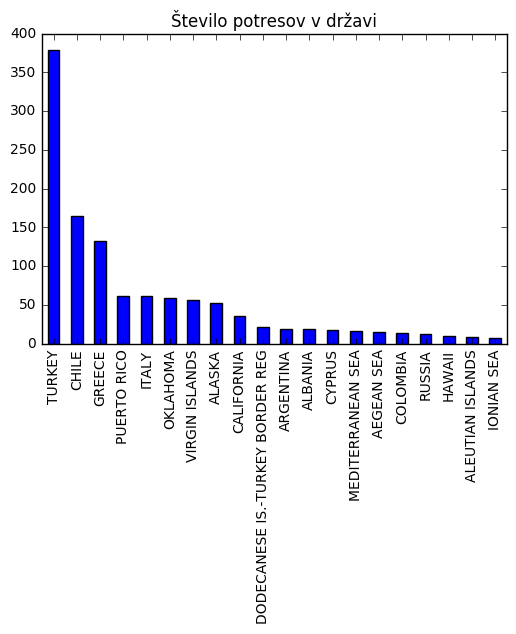

In [103]:
stevilo_drzava.head(20).plot(kind='bar', title='Število potresov v državi')

Izpišimo potrese z največjo magnitudo, saj nas ta podatek običajno zelo zanima. Najprej izpišimo posamezne najmočnejše potrese, ki so se zgodili v prvi polovici oktobra. Zanimivo je, da Turčije na vrhu seznama ne najdemo (za razliko od Grčije in Čila). Sklepamo torej, da bi bilo potrebno pogledati tudi tabelo s povprečno magnitudo, ki jo bomo izpisali spodaj.

In [104]:
delno = podatki[['regija', 'drzava', 'magnituda']]
delno.sort_values('magnituda', ascending=False)[:15]

,regija,drzava,magnituda
id,,,
535107,"BONIN ISLANDS, JAPAN REGION",JAPAN,5.7
535361,"LUZON, PHILIPPINES",PHILIPPINES,5.7
537318,GREECE,GREECE,5.4
536858,SOUTHEAST OF EASTER ISLAND,SOUTHEAST OF EASTER ISLAND,5.4
534540,PAKISTAN,PAKISTAN,5.3
536551,"MINDORO, PHILIPPINES",PHILIPPINES,5.3
537149,BLACK SEA,BLACK SEA,5.2
534884,"NORTHERN SUMATRA, INDONESIA",INDONESIA,5.0
535942,SAMOA ISLANDS REGION,SAMOA ISLANDS,5.0


### Razna povprečja

Sedaj si oglejmo še povprečne magnitude. Opazimo, da se pojavijo mnoge države iz zgornje tabele. Kako bi si to razložili?

Na rezultate gotovo vpliva relativno majhno skupno število podatkov in izredno velik razpon v številu podatkov za posamezno državo. Zato teh povprečnih vrednosti ne smemo jemati preresno. Opozorila bi recimo na primer Pakistana. Očitno se je tam v opazovanem času zgodil le en potres (tabela stevilo_drzava zgoraj), ki pa je bil izredno močan (magnituda 5.3 v zgornji tabeli). S primerjavo tabel nad in pod tem besediom vidimo, da se je v mnogih državah zgodil le en močan potres, tako da težko govorimo o verodostojni povprečni vrednosti.

In [138]:
drzave = podatki.groupby('drzava')

drzave['magnituda'].mean().sort_values(ascending=False).round(2)[:15]

drzava
SOUTHEAST OF EASTER ISLAND    5.40
PAKISTAN                      5.30
BLACK SEA                     5.20
PHILIPPINES                   5.17
SAMOA ISLANDS                 5.00
WEST CHILE RISE               5.00
SOUTH SANDWICH ISLANDS        5.00
INDONESIA                     5.00
JAPAN                         4.95
SANTA CRUZ ISLANDS            4.90
PERU                          4.90
NORTH ATLANTIC OCEAN          4.90
SOUTHWEST INDIAN RIDGE        4.80
FIJI                          4.75
TONGA                         4.70
Name: magnituda, dtype: float64

Izkoristimo še stolpca 'DOL' in 'SIR', ki vsebujeta podatke o geografski širini in dolžini, in sicer samo vrednosti N, S, E, W za strani neba. Spodnji graf prikazuje, kolikšen delež zaznanih potresov se je zgodil na severni in južni polobli. Porazdelitev je presenetljiva, saj za tako nenavadno razmerje navidez ni vzroka. Dodala sem podatek o povprečni magnitudi za eno in drugo poloblo.

Zakaj pa nas ti podatki vendale ne presenečajo tako zelo? EMSC (vir podatkov) je evropska mreža. Kot sem zapisala v uvodu, je večina opazovalnic v Evropi, kar pomeni, da z večjo natančnostjo zaznajo tudi manj močne potrese na tem območju (in podatke posredujejo EMSC). Drugače povedano - šibak potres npr. v Švici bo zabeležen, enako močan v Južnoafriški republiki pa ne, ker ga evropske opazovalnice ne bodo zaznale (predpostavimo, da recimo nobena bližnja opazovalnica ni vključena v mrežo). Drug faktor je porazdelitev kopnega - tudi če bi bile EMSC-jeve opazovalnice enakomerno razporejene po državah po svetu, je na južni polobli pač manj kopnega in posledično manj opazovalnic.

Podatki o mediani in povprečni magnitudi potrjujejo zgoraj zapisano - tisti potresi z južne poloble, ki so jih zaznali, so bili močnejši, posledično sta prikazani vrednosti višji.

Pri delitvi vzhod-zahod so razultati manj presenetljivi.

(SIR
 N    2.4
 S    3.1
 Name: magnituda, dtype: float64, SIR
 N    2.63
 S    3.29
 Name: magnituda, dtype: float64)

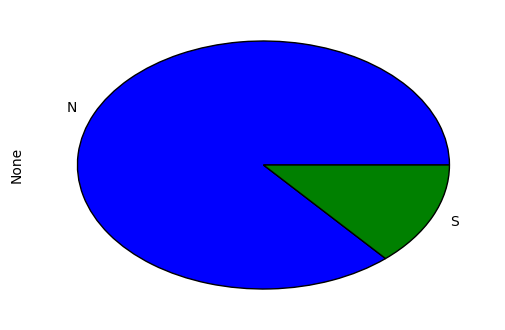

In [145]:
sirina = podatki.groupby('SIR')
sirina.size().plot(kind = 'pie')

sirina['magnituda'].median(), sirina['magnituda'].mean().round(2)

(DOL
 E    2.3
 W    2.8
 Name: magnituda, dtype: float64, DOL
 E    2.56
 W    2.94
 Name: magnituda, dtype: float64)

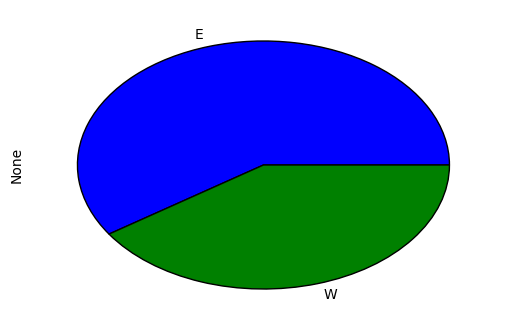

In [146]:
dolzina = podatki.groupby('DOL')
dolzina.size().plot(kind = 'pie')

dolzina['magnituda'].median(), dolzina['magnituda'].mean().round(2)

## Kdaj so se zgodili potresi?

Osnovna hipoteza je, da so potresi bolj ali manj časovno neodvisni pojavi, zato povsod pričakujemo enakomerne porazdelitve - tako glede na dan v tednu kot na primer glede na uro v dnevu.

Za začetek narišimo graf števila zaznanih potresov za vsak dan, ob tem si oglejmo še mediane vrednosti magnitud. Kot smo pričakovali, velikih odstopanj ni. Jasno je, da bi lepše (torej enakomernejše) grafe dobili z večjim številom zajetih podatkov.

dan
1     2.90
2     2.40
3     2.50
4     2.60
5     2.65
6     2.60
7     2.50
8     2.50
9     2.40
10    2.50
11    2.30
12    2.30
13    2.40
14    2.60
15    2.60
Name: magnituda, dtype: float64

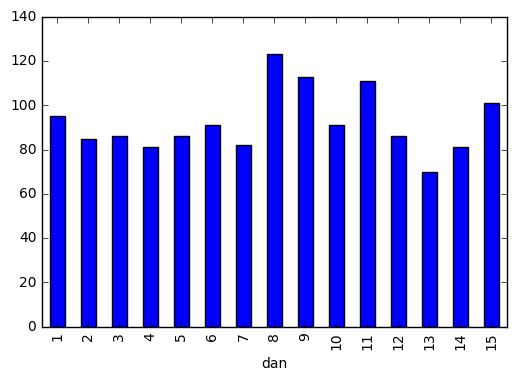

In [186]:
po_dnevu = podatki.groupby('dan')
po_dnevu.size().plot(kind='bar')
po_dnevu['magnituda'].median()

Opazimo razliko med [18] in [19], hipoteza morje - kopno...

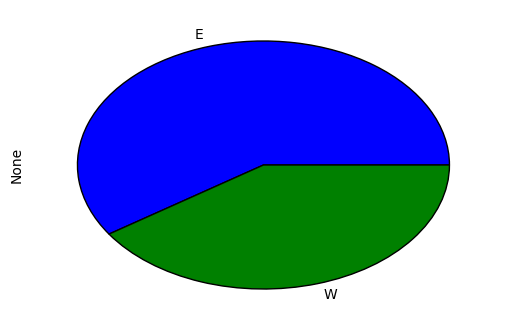

In [111]:
dolzina = podatki.groupby('DOL')
dolzina.size().plot(kind='pie')

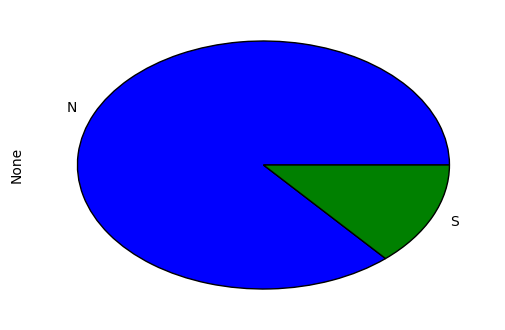

In [14]:
sirina = podatki.groupby('SIR')
#sirina['magnituda'].mean()
sirina.size().plot(kind = 'pie')

zanimivo. opazovalnice, Afrika, morje...?

In [ ]:
globina = podatki.groupby('globina')
globina.size().plot()

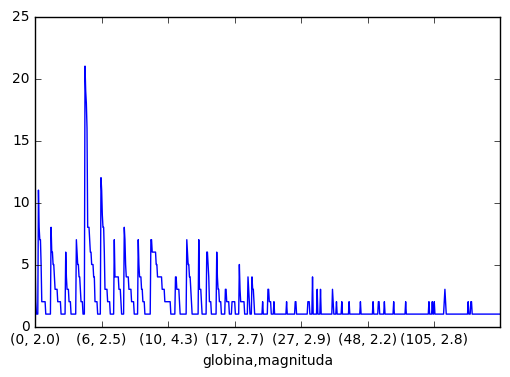

In [164]:
#podatki.groupby('globina')['magnituda'].mean().plot()
podatki.groupby('globina')['magnituda'].value_counts().plot()
#podatki.groupby('globina')['magnituda'].size().plot()

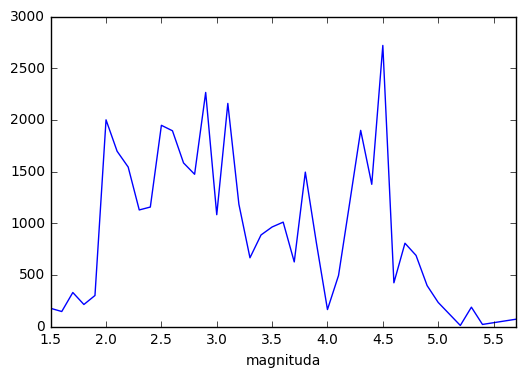

In [121]:
podatki.groupby('magnituda')['globina'].sum().plot()

In [ ]:
podatki.groupby('magnituda')['globina'].mean().plot()